In [1]:
import os
import time

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchaudio
import torchaudio.transforms as T
from tqdm import tqdm
import glob
import csv
import soundfile as sf
import sounddevice as sd
import numpy as np
from prettytable import PrettyTable


# 定义调试信息函数
def debug_print(message, level="INFO"):
    print(f"[{level}] {message}")


# 1. 定义 TDNN 层
class TDNNLayer(nn.Module):
    def __init__(self, input_dim, output_dim, context_size, dilation=1):
        super(TDNNLayer, self).__init__()
        self.tdnn = nn.Conv1d(in_channels=input_dim,
                              out_channels=output_dim,
                              kernel_size=context_size,
                              stride=1,
                              dilation=dilation)
        self.activation = nn.LeakyReLU()

    def forward(self, x):
        out = self.tdnn(x)
        out = self.activation(out)
        return out


# 2. 定义统计池化层
class StatsPooling(nn.Module):
    def forward(self, x):
        mean = torch.mean(x, dim=2)
        std = torch.std(x, dim=2)
        stats = torch.cat((mean, std), dim=1)
        return stats


# 3. 定义 XVector 模型
class XVector(nn.Module):
    def __init__(self):
        super(XVector, self).__init__()
        self.tdnn1 = TDNNLayer(input_dim=64, output_dim=512, context_size=5, dilation=1)
        self.tdnn2 = TDNNLayer(input_dim=512, output_dim=512, context_size=3, dilation=2)
        self.tdnn3 = TDNNLayer(input_dim=512, output_dim=512, context_size=3, dilation=3)
        self.tdnn4 = TDNNLayer(input_dim=512, output_dim=512, context_size=1, dilation=1)
        self.tdnn5 = TDNNLayer(input_dim=512, output_dim=1500, context_size=1, dilation=1)
        self.stats_pooling = StatsPooling()
        self.embedding1 = nn.Linear(3000, 512)
        self.embedding1_act = nn.LeakyReLU()

    def forward(self, x):
        x = self.tdnn1(x)
        x = self.tdnn2(x)
        x = self.tdnn3(x)
        x = self.tdnn4(x)
        x = self.tdnn5(x)
        x = self.stats_pooling(x)
        x = self.embedding1(x)
        x = self.embedding1_act(x)
        return x


# 4. 定义分类器
class Classifier(nn.Module):
    def __init__(self, num_classes):
        super(Classifier, self).__init__()
        self.fc1 = nn.Linear(512, 512)
        self.fc1_act = nn.LeakyReLU()
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.fc1(x)
        x = self.fc1_act(x)
        x = self.fc2(x)
        return x


# 5. 定义整个模型
class SpeechCommandModel(nn.Module):
    def __init__(self, num_classes):
        super(SpeechCommandModel, self).__init__()
        self.feature_extractor = T.MelSpectrogram(sample_rate=16000, n_mels=64)
        self.xvector = XVector()
        self.classifier = Classifier(num_classes=num_classes)

    def forward(self, x):
        features = self.feature_extractor(x)
        features = features.clamp(min=1e-9).log()
        features = features.squeeze(1)  # 移除不必要的维度
        embedding = self.xvector(features)
        outputs = self.classifier(embedding)
        return outputs


# 6. 定义标签到索引和索引到标签的映射
all_labels = ['backward', 'bed', 'bird', 'cat', 'dog', 'down', 'eight', 'five',
              'follow', 'forward', 'four', 'go', 'happy', 'house', 'learn',
              'left', 'marvin', 'nine', 'no', 'off', 'on', 'one', 'right',
              'seven', 'sheila', 'six', 'stop', 'three', 'tree', 'two', 'up',
              'visual', 'wow', 'yes', 'zero']
labels_to_index = {label: idx for idx, label in enumerate(all_labels)}
index_to_labels = {idx: label for label, idx in labels_to_index.items()}
num_classes = len(all_labels)


In [2]:
# 7. 定义预测函数
def predict(audio_path, model, device, index_to_labels):
    try:
        # 使用 soundfile 加载音频文件
        audio, sr = sf.read(audio_path)

        # 确保音频是单声道的
        if len(audio.shape) > 1:
            audio = np.mean(audio, axis=1)

        # 转换为 torch tensor
        waveform = torch.from_numpy(audio).float().unsqueeze(0)

        # 如果采样率不是16000，需要进行重采样
        if sr != 16000:
            resampler = T.Resample(sr, 16000)
            waveform = resampler(waveform)

        # 将音频数据移到设备上
        waveform = waveform.to(device)

        # 模型推理
        with torch.no_grad():
            # 模型要求输入形状为[batch_size, time]
            if len(waveform.shape) == 2:
                waveform = waveform.unsqueeze(0)  # 添加batch维度
            outputs = model(waveform)
            probabilities = F.softmax(outputs, dim=1)
            _, predicted = torch.max(outputs, dim=1)

        # 获取预测的标签
        predicted_index = predicted.item()
        predicted_label = index_to_labels.get(predicted_index, "未知")

        return predicted_label, probabilities.cpu().numpy()
    except Exception as e:
        debug_print(f"预测过程中出错: {audio_path}, 错误: {e}", level="ERROR")
        return None, None


# 8. 定义预测文件夹内的所有.wav文件
def predict_folder(folder_path, model, device, index_to_labels):
    wav_files = glob.glob(os.path.join(folder_path, '*.wav'))
    predictions = []
    for wav_file in tqdm(wav_files, desc='预测文件夹', unit='file'):
        predicted_label, probabilities = predict(wav_file, model, device, index_to_labels)
        if predicted_label is not None:
            filename = os.path.basename(wav_file)
            predictions.append((filename, predicted_label))
            debug_print(f"文件: {filename}, 识别结果: {predicted_label}", level="INFO")
        else:
            debug_print(f"跳过文件: {wav_file}", level="WARNING")
    return predictions


# 9. 定义预测单个.wav文件
def predict_single_file(audio_path, model, device, index_to_labels):
    predicted_label, probabilities = predict(audio_path, model, device, index_to_labels)
    if predicted_label is not None:
        debug_print(f"文件: {os.path.basename(audio_path)}, 预测标签: {predicted_label}", level="INFO")
        # 如果需要查看每个类别的概率，可以取消以下注释
        # debug_print("每个类别的概率:", level="DEBUG")
        # for i, prob in enumerate(probabilities[0]):
        #     label = index_to_labels[i]
        #     debug_print(f"{label}: {prob:.4f}", level="DEBUG")
    else:
        debug_print(f"无法预测文件: {audio_path}", level="ERROR")


if __name__ == "__main__":
    debug_print(f"Number of classes: {num_classes}")
    debug_print(f"Classes: {all_labels}", level="DEBUG")

    # 10. 创建模型并加载最佳模型参数
    model = SpeechCommandModel(num_classes=num_classes)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    debug_print(f"将模型移动到设备: {device}")

    # 设置模型路径
    model_path = r'.\speech_commands_model_epoch_20_9621--64mel.pth'


    if os.path.exists(model_path):
        model.load_state_dict(torch.load(model_path, map_location=device))
    else:
        debug_print(f"模型文件不存在: {model_path}", level="ERROR")
        exit(1)

    model.eval()
    # debug_print("模型已切换为评估模式")

[INFO] Number of classes: 35
[DEBUG] Classes: ['backward', 'bed', 'bird', 'cat', 'dog', 'down', 'eight', 'five', 'follow', 'forward', 'four', 'go', 'happy', 'house', 'learn', 'left', 'marvin', 'nine', 'no', 'off', 'on', 'one', 'right', 'seven', 'sheila', 'six', 'stop', 'three', 'tree', 'two', 'up', 'visual', 'wow', 'yes', 'zero']
[INFO] 将模型移动到设备: cpu


C:\Users\22751\AppData\Local\Temp\ipykernel_1540\3792931506.py:85: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=de

In [3]:
# 11. 识别单次录音
from matplotlib.colors import LinearSegmentedColormap
def record_and_predict(duration, model, device, index_to_labels, plot=False):
    print(f"开始录音 {duration} 秒...")
    sample_rate = 16000  # 保持与模型一致
    recording = sd.rec(int(duration * sample_rate), samplerate=sample_rate, channels=1)
    sd.wait()  # 等待录音完成
    print("录音完成")
    
    # 开始计时
    start_time = time.time()

    # 将录音数据转换为 torch tensor
    waveform = torch.from_numpy(recording).float().t()

    # 确保波形是单声道的
    if waveform.dim() > 1:
        waveform = waveform.mean(dim=0)
    else:
        waveform = waveform.squeeze()

    # 进行预测
    waveform = waveform.to(device)
    with torch.no_grad():
        waveform = waveform.unsqueeze(0)  # 添加 batch 维度
        outputs = model(waveform)
        probabilities = F.softmax(outputs, dim=1)
        _, predicted = torch.max(outputs, dim=1)

    # 结束计时
    end_time = time.time()
    prediction_time = end_time - start_time

    # 获取预测的标签
    predicted_index = predicted.item()
    predicted_label = index_to_labels.get(predicted_index, "未知")
    
    print(f"预测结果: {predicted_label}")
    print(f"预测用时: {prediction_time:.4f} 秒")

    if plot:
        import matplotlib.pyplot as plt

        # 绘制原始波形图
        plt.figure(figsize=(12.12, 5))
        time_axis = np.linspace(0, duration, len(waveform.squeeze()))
        plt.plot(time_axis, waveform.squeeze().cpu().numpy())
        plt.title("Waveform")
        plt.xlabel("Time(s)")
        plt.ylabel("Amplitude")
        plt.show()

        # 获取梅尔频谱
        features = model.feature_extractor(waveform)
        features = features.clamp(min=1e-9).log()
        features = features.squeeze(0).cpu().numpy()

        # 创建自定义的深蓝到浅绿的颜色映射
        colors = [
            (0, 0, 0),      
            (0, 0.5, 0),   
            (0, 1, 0)        
        ]
        blue_to_green = LinearSegmentedColormap.from_list("blue_to_green", colors, N=256)

        # 绘制频谱图
        plt.figure(figsize=(15, 5))
        plt.imshow(features, aspect='auto', origin='lower', 
                  extent=[0, duration, 0, features.shape[0]], 
                  cmap=blue_to_green)  # 使用自定义的颜色映射
        plt.title("Spectrum")
        plt.xlabel("Time(s)")
        plt.ylabel("Frequency(Hz)")
        plt.colorbar(format='%+2.0f dB')
        plt.show()

    return predicted_label, probabilities.cpu().numpy()

准备开始录音和识别...
开始录音 2 秒...
录音完成
预测结果: visual
预测用时: 0.0155 秒


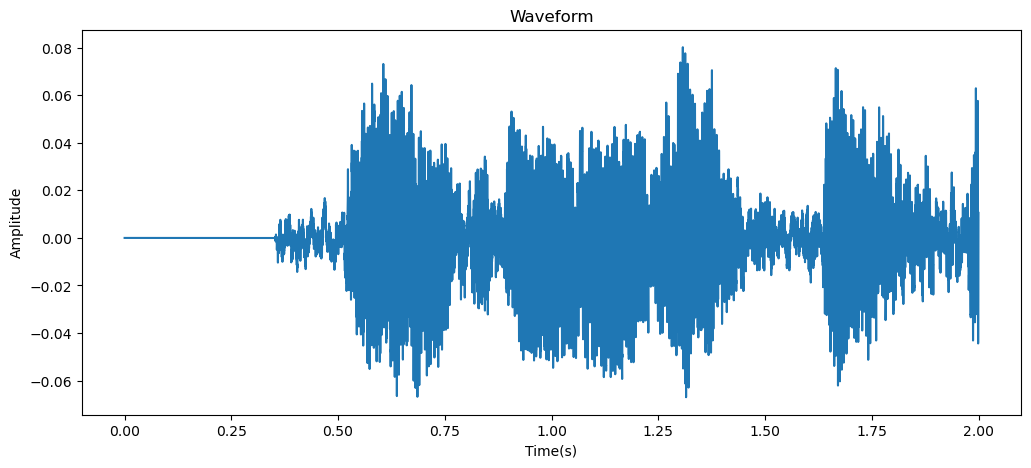

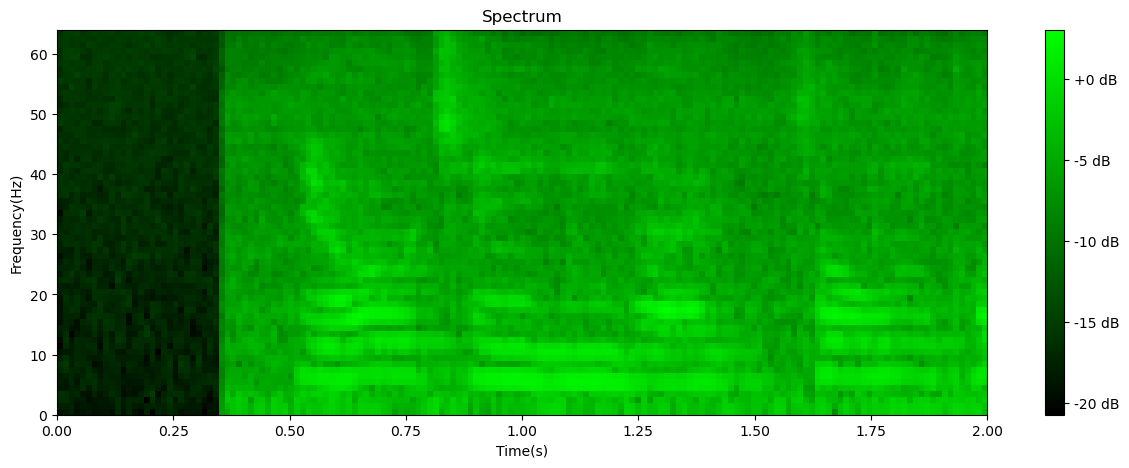

In [4]:
    print("准备开始录音和识别...")
    # time.sleep(1)
    record_duration = 2  # 录音持续2秒
    predicted_label, probabilities = record_and_predict(record_duration, model, device, index_to_labels, plot=True)

In [5]:
# 12. 实现连续的录音和预测
import torch
import torch.nn.functional as F
import sounddevice as sd
import numpy as np
import time
from prettytable import PrettyTable
import wave
import os

def save_audio(waveform, sample_rate, count):
    os.makedirs("debug_audio", exist_ok=True)
    filename = f"debug_audio/audio_{count}.wav"
    waveform_np = waveform.numpy()
    with wave.open(filename, 'wb') as wf:
        wf.setnchannels(1)
        wf.setsampwidth(2)
        wf.setframerate(sample_rate)
        wf.writeframes((waveform_np * 32767).astype(np.int16).tobytes())

def predict_and_display(model, device, waveform, index_to_labels, start_time, end_time, audio_count):
    waveform = waveform.to(device)
    with torch.no_grad():
        waveform = waveform.unsqueeze(0)
        outputs = model(waveform)
        _, predicted = torch.max(outputs, dim=1)

    predicted_index = predicted.item()
    predicted_label = index_to_labels.get(predicted_index, "未知")

    print(f"({start_time:.3f}s, {end_time:.3f}s): {predicted_label}")

def continuous_recording_and_prediction(model, device, index_to_labels, chunk_duration=0.01, min_silence_duration=0.3, threshold_update_interval=0.5):
    print("\n开始连续录音和识别。说话时会自动检测并预测单词...")
    sample_rate = 16000
    chunk_samples = int(chunk_duration * sample_rate)
    target_length = int(3 * sample_rate)

    # 自适应阈值相关参数
    noise_levels = []
    NOISE_MEMORY = 50
    NOISE_MULTIPLIER = 1.5
    MIN_THRESHOLD = 0.01
    MAX_THRESHOLD = 0.1
    
    # 阈值更新相关变量
    last_threshold_update = time.time()
    current_threshold = MIN_THRESHOLD  # 初始阈值
    temp_energies = []  # 临时存储能量值

    try:
        stream = sd.InputStream(samplerate=sample_rate, channels=1, blocksize=chunk_samples)
    except Exception as e:
        print(f"无法打开音频流: {e}")
        return

    def update_threshold(energy_values, noise_levels):
        """
        更新自适应阈值
        
        参数:
        - energy_values: 累积的能量值列表
        - noise_levels: 历史噪声水平列表
        """
        # 计算平均能量
        avg_energy = np.mean(energy_values)
        
        # 更新噪声水平历史
        noise_levels.append(float(avg_energy))
        if len(noise_levels) > NOISE_MEMORY:
            noise_levels.pop(0)
        
        # 计算新阈值
        background_noise = np.mean(noise_levels)
        return min(max(background_noise * NOISE_MULTIPLIER, MIN_THRESHOLD), MAX_THRESHOLD)

    with stream:
        buffer = []
        silence_duration = 0
        is_speaking = False
        start_time = None
        audio_count = 0
        global_start_time = time.time()

        # 初始化阶段
        # print("初始化阈值：收集背景噪声样本...")
        for _ in range(20):
            recording, _ = stream.read(chunk_samples)
            waveform = torch.from_numpy(recording).float().squeeze().t()
            energy = torch.mean(torch.abs(waveform))
            noise_levels.append(float(energy))
        current_threshold = update_threshold([float(energy)], noise_levels)
        # print("初始化阈值完成，开始识别...")
        print("初始化完成，开始识别...")

        while True:
            try:
                recording, _ = stream.read(chunk_samples)
            except Exception as e:
                print(f"读取音频数据时出错: {e}")
                continue

            waveform = torch.from_numpy(recording).float().squeeze().t()
            energy = torch.mean(torch.abs(waveform))
            
            # 收集能量值
            temp_energies.append(float(energy))

            # 检查是否需要更新阈值
            current_time = time.time()
            if current_time - last_threshold_update >= threshold_update_interval:
                if temp_energies:  # 确保有数据
                    current_threshold = update_threshold(temp_energies, noise_levels)
                    temp_energies = []  # 清空临时存储
                last_threshold_update = current_time

            # 使用当前阈值进行语音检测
            if energy > current_threshold:
                silence_duration = 0
                if not is_speaking:
                    is_speaking = True
                    start_time = time.time()
                    buffer = []
                buffer.append(waveform)
            else:
                silence_duration += chunk_duration
                if is_speaking and silence_duration >= min_silence_duration:
                    is_speaking = False
                    if buffer:
                        full_waveform = torch.cat(buffer)
                        
                        if full_waveform.size(0) < target_length:
                            repeat_times = target_length // full_waveform.size(0)
                            repeated_waveform = full_waveform.repeat(repeat_times)
                            remaining = target_length - repeated_waveform.size(0)
                            if remaining > 0:
                                zero_padding = torch.zeros(remaining)
                                full_waveform = torch.cat([repeated_waveform, zero_padding])
                            else:
                                full_waveform = repeated_waveform
                        elif full_waveform.size(0) > target_length:
                            full_waveform = full_waveform[:target_length]

                        end_time = time.time()
                        audio_count += 1
                        save_audio(full_waveform, sample_rate, audio_count)
                        predict_and_display(model, device, full_waveform, index_to_labels, 
                                         start_time - global_start_time, 
                                         end_time - global_start_time, audio_count)
                    buffer = []
                elif is_speaking:
                    buffer.append(waveform)

In [7]:
continuous_recording_and_prediction(model, device, index_to_labels)


开始连续录音和识别。说话时会自动检测并预测单词...
初始化完成，开始识别...
(0.610s, 1.303s): zero
(1.892s, 2.524s): one
(3.164s, 3.727s): two


KeyboardInterrupt: 

In [10]:
# 13. 对单个.wav文件进行预测
single_audio_path = r'.\speech_commands_6\go.wav'
if os.path.exists(single_audio_path):
    debug_print(f"开始预测单个文件: {single_audio_path}", level="INFO")
    predict_single_file(single_audio_path, model, device, index_to_labels)
else:
    debug_print(f"音频文件不存在: {single_audio_path}", level="ERROR")

[INFO] 开始预测单个文件: .\speech_commands_6\go.wav
[INFO] 文件: go.wav, 预测标签: go


In [11]:
# 14. 对文件夹内的所有.wav文件进行预测
audio_folder_path = r'./speech_commands_6'

if os.path.exists(audio_folder_path):
    debug_print("开始预测文件夹内所有 .wav 文件:", level="INFO")
    predictions = predict_folder(audio_folder_path, model, device, index_to_labels)
    # 保存预测结果到 CSV
    if predictions:
        csv_path = os.path.join(audio_folder_path, 'predictions.csv')
        try:
            with open(csv_path, 'w', newline='', encoding='utf-8') as csvfile:
                writer = csv.writer(csvfile)
                writer.writerow(['Filename', 'Predicted Label'])
                writer.writerows(predictions)
            debug_print(f"预测结果已保存到 {csv_path}", level="INFO")
        except Exception as e:
            debug_print(f"保存预测结果到 CSV 时出错: {e}", level="ERROR")
    else:
        debug_print("没有可保存的预测结果。", level="WARNING")
else:
    debug_print(f"文件夹不存在: {audio_folder_path}", level="ERROR")

[INFO] 开始预测文件夹内所有 .wav 文件:


预测文件夹: 100%|██████████| 13/13 [00:00<00:00, 133.71file/s]

[INFO] 文件: backward.wav, 识别结果: backward
[INFO] 文件: backward2.wav, 识别结果: backward
[INFO] 文件: forward.wav, 识别结果: four
[INFO] 文件: forward2.wav, 识别结果: four
[INFO] 文件: go.wav, 识别结果: go
[INFO] 文件: go2.wav, 识别结果: go
[INFO] 文件: left.wav, 识别结果: left
[INFO] 文件: left2.wav, 识别结果: left
[INFO] 文件: right.wav, 识别结果: right
[INFO] 文件: right2.wav, 识别结果: right
[INFO] 文件: right3.wav, 识别结果: right
[INFO] 文件: stop.wav, 识别结果: stop
[INFO] 文件: stop2.wav, 识别结果: stop
[INFO] 预测结果已保存到 ./speech_commands_6\predictions.csv
